In [52]:
# importing dependencies
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# For model building
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestRegressor

## This notebook will be used for building a random forest in python.

In [53]:
# Load in the data
weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data

temp = []
for x in [2013 + x for x in range(5)] :
    x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
    temp.append(x)
    nr = pd.concat(temp)

In [54]:
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start_date'] = nr['Start_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
nr['End_date'] = nr['End_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

Correcting missing data in the weather dataframe

In [55]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

### Preparing the data to be used for the model

In [56]:
# Resampling our NR data so it takes the start date and Total duration, returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start_date', 'duration']].resample('D', on='Start_date').count()
daily_totals = daily_totals.drop('Start_date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"duration": "daily_count",'Start_date':'DATE'})

In [57]:
print(daily_totals.head())
print(daily_totals.describe())

        DATE  daily_count
0 2013-01-10            1
1 2013-01-11            0
2 2013-01-12            0
3 2013-01-13            0
4 2013-01-14            0
       daily_count
count  1761.000000
mean   1189.301533
std    1182.379065
min       0.000000
25%       0.000000
50%    1091.000000
75%    2204.000000
max    5625.000000


In [58]:
nr.keys()

Index(['Start_date', 'Start_name', 'Start_id', 'End_date', 'End_name',
       'End_id', 'duration', 'account'],
      dtype='object')

In [59]:
daily_means = nr[['Start_date', 'duration']].resample('D', on='Start_date').mean()
daily_means = daily_means.reset_index()
daily_means = daily_means.rename(index=str, columns={"duration": "daily_mean",'Start_date':'DATE'})

In [60]:
len(daily_means)

1761

The daily totals DataFrame looks good

In [61]:
print(weather.keys())
# The weather station and name won't be necessary or add anything to our analysis
weather = weather.drop(['STATION', 'NAME'], axis=1)

Index(['STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN'],
      dtype='object')


In [62]:
weather.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9


In [63]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp = temp.merge(daily_means, how='outer',on='DATE')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    1761 non-null float64
daily_mean     1080 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 251.1 KB


,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,NaN,NaN
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,NaN,NaN
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,NaN,NaN
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,NaN,NaN
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,NaN,NaN


In [64]:
# Notice how the count of DCOUNT varies from what the other columns have
features = temp.fillna(value=0,axis=0) # Where we don't have a daily count (Dcount) fill this with zeros instead
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
daily_mean     2922 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 251.1 KB


In [65]:
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0


This next section will change our date column from dtype datetime into seperate numerical relevant date colummns

In [66]:
features['YEAR'] = features['DATE'].dt.year
features['MONTH'] = features['DATE'].dt.month
features['DAY'] = features['DATE'].dt.day

In [67]:
features.head() # Three new, seperate, columns that identify year, month, day

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0,2010,1,1
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0,2010,1,2
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0,2010,1,3
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0,2010,1,4
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0,2010,1,5


In [68]:
# Create a weekday variable column Mon = 0, Sun = 6
features['WEND'] = features['DATE'].dt.weekday

In [69]:
# Adjust WEND column to be catagorical; If it's a weekday WEND = 0 else if weekend WEND = 1
features['WEND'] = features['WEND'].apply(lambda x:1 if x>4 else 0)
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0,2010,1,1,0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0,2010,1,2,1
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0,2010,1,3,1
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0,2010,1,4,0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0,2010,1,5,0


In [70]:
# Random forests can't use datetime objects
features = features.drop('DATE', axis=1)

In [71]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 13 columns):
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
daily_mean     2922 non-null float64
YEAR           2922 non-null int64
MONTH          2922 non-null int64
DAY            2922 non-null int64
WEND           2922 non-null int64
dtypes: float64(6), int64(7)
memory usage: 319.6 KB


In [72]:
# Seperating our data sets
winter_features = features[features['daily_count'] == 0].reset_index(drop=True)

# Need to drop all days where there where no rides taken (Dcount = 0)
features = features[features['daily_count'] != 0].reset_index(drop=True)

In [73]:
features.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,9.101806,0.133750,0.021944,0.090741,62.422685,71.354630,53.541667,1939.222222,2541.934202,2014.995370,7.072222,15.802778,0.285185
std,3.320652,0.357112,0.275489,0.698938,12.925530,13.925633,12.531485,908.160793,11111.184380,1.424978,2.073346,8.857590,0.451712
min,0.890000,0.000000,0.000000,0.000000,8.000000,19.000000,-3.000000,1.000000,11.000000,2013.000000,1.000000,1.000000,0.000000
25%,6.710000,0.000000,0.000000,0.000000,54.000000,63.000000,44.000000,1302.250000,1142.270481,2014.000000,5.000000,8.000000,0.000000
50%,8.720000,0.000000,0.000000,0.000000,65.000000,75.000000,56.000000,1957.500000,1492.317172,2015.000000,7.000000,16.000000,0.000000
75%,11.410000,0.070000,0.000000,0.000000,72.000000,82.000000,63.000000,2598.000000,1987.761163,2016.000000,9.000000,23.250000,1.000000
max,21.250000,4.130000,6.400000,8.000000,87.000000,98.000000,80.000000,5625.000000,330526.000000,2017.000000,11.000000,31.000000,1.000000


DCOUNT shows Minimum of at least 1, and the

I'm concerned why month shows min 1; there shouldn't be any data for January still. Time to investigate further

In [74]:
features[features.MONTH == 1]

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
0,10.29,0.28,0.0,2,31.5,39,24,1.0,106.0,2013,1,10,0


In [75]:
type(features.MONTH)

pandas.core.series.Series

Data looks good!

### Features, Targets, and converting Data in Arrays (optimizes performance)

In [76]:
# Saving the target/label variable and removing from features Dataframe
target = features.daily_count.values
feat = features.drop('daily_count', axis=1).values

# Saving the feature names for future use
feature_names = list(features.drop('daily_count', axis=1).columns)

In [77]:
# Splitting the data into training and test sets
X, X_test, y, y_test = train_test_split(feat, target, test_size=.25, random_state=42)

Inspecting the shape of the features and labels

In [78]:
print('Training Features shape', X.shape)
print('Training labels shape', y.shape)

print('Testing Features shape', X_test.shape)
print('Testing labels shape', y_test.shape)

Training Features shape (810, 12)
Training labels shape (810,)
Testing Features shape (270, 12)
Testing labels shape (270,)


## Establishing a baseline

Need to find what a good baseline would be

In [79]:
'''
Insert baseline creation code here
'''

'\nInsert baseline creation code here\n'

## Training the data

In [80]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Making predictions on the test set

In [81]:
predictions = rf.predict(X_test)

## Assessing the performance of our RandomForestRegressor

This is the r2 score

In [82]:
cv_r2 = cross_val_score(rf, X, y, cv=10)
print(cv_r2)
print(np.mean(cv_r2))

[ 0.81315708  0.79711476  0.77655665  0.78259305  0.74046167  0.81615271
  0.82478691  0.84100266  0.83619485  0.83498846]
0.8063008799


In [83]:
cv_negMSElog_error = cross_val_score(rf, X, y, scoring='neg_mean_squared_log_error', cv=5)
print(cv_negMSElog_error)
print(np.mean(cv_negMSElog_error))

[-0.21543183 -0.20290699 -0.17536054 -0.15745856 -0.1098469 ]
-0.172200965469


In [84]:
errors = abs(predictions - y_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2))

Mean Absolute Error:  301.5


In [85]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', np.round(accuracy, 2), '%')

Accuracy:  42.76 %


In [86]:
(errors == y_test).mean()

0.0

In [87]:
# Mean Absolute Square

In [88]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TMAX                 Importance: 0.6
Variable: daily_mean           Importance: 0.12
Variable: PRCP                 Importance: 0.08
Variable: YEAR                 Importance: 0.04
Variable: AWND                 Importance: 0.03
Variable: TAVG                 Importance: 0.03
Variable: MONTH                Importance: 0.03
Variable: DAY                  Importance: 0.03
Variable: TMIN                 Importance: 0.02
Variable: WEND                 Importance: 0.02
Variable: SNOW                 Importance: 0.0
Variable: SNWD                 Importance: 0.0


## Visualizing the features and predictions

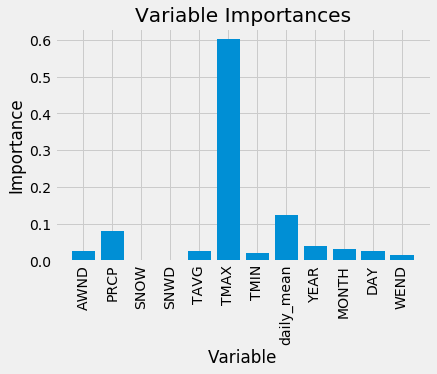

In [89]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

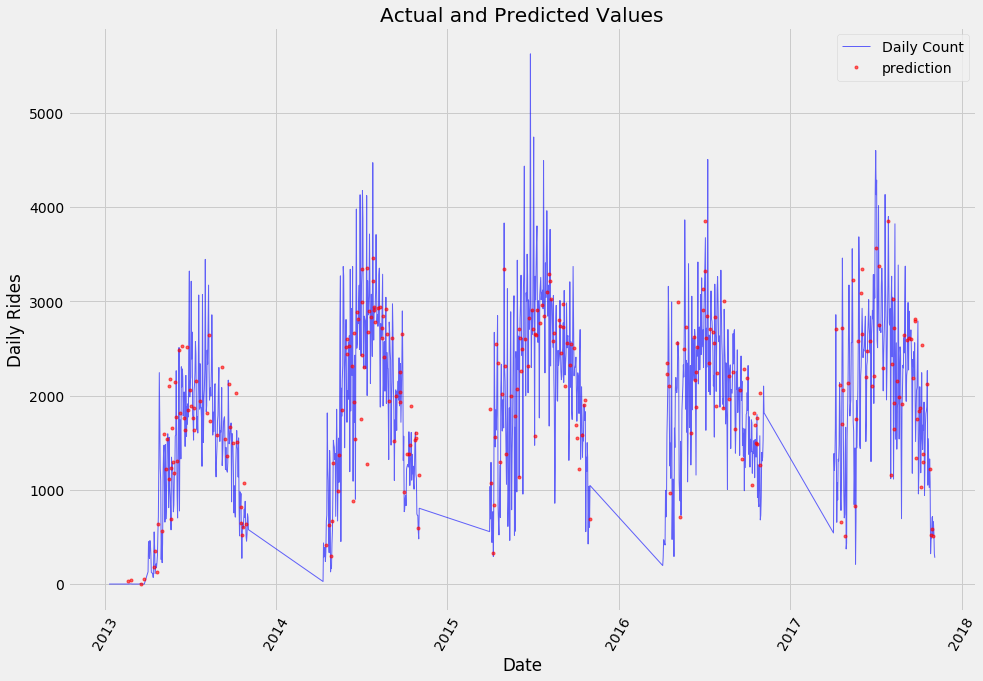

In [90]:
# Dates of training values
days = feat[:, feature_names.index('DAY')]
months = feat[:, feature_names.index('MONTH')]
years = feat[:, feature_names.index('YEAR')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'DCOUNT': target})

# Dates of predictions
months = X_test[:, feature_names.index('MONTH')]
days = X_test[:, feature_names.index('DAY')]
years = X_test[:, feature_names.index('YEAR')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['date'], true_data['DCOUNT'], 'b', label = 'Daily Count', linewidth=1, alpha=.6)

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Daily Rides'); plt.title('Actual and Predicted Values');

In [91]:
print(features.TMAX.values.shape)
print(target.shape)
print(X_test[:,5].shape)
print(predictions.shape)

(1080,)
(1080,)
(270,)
(270,)


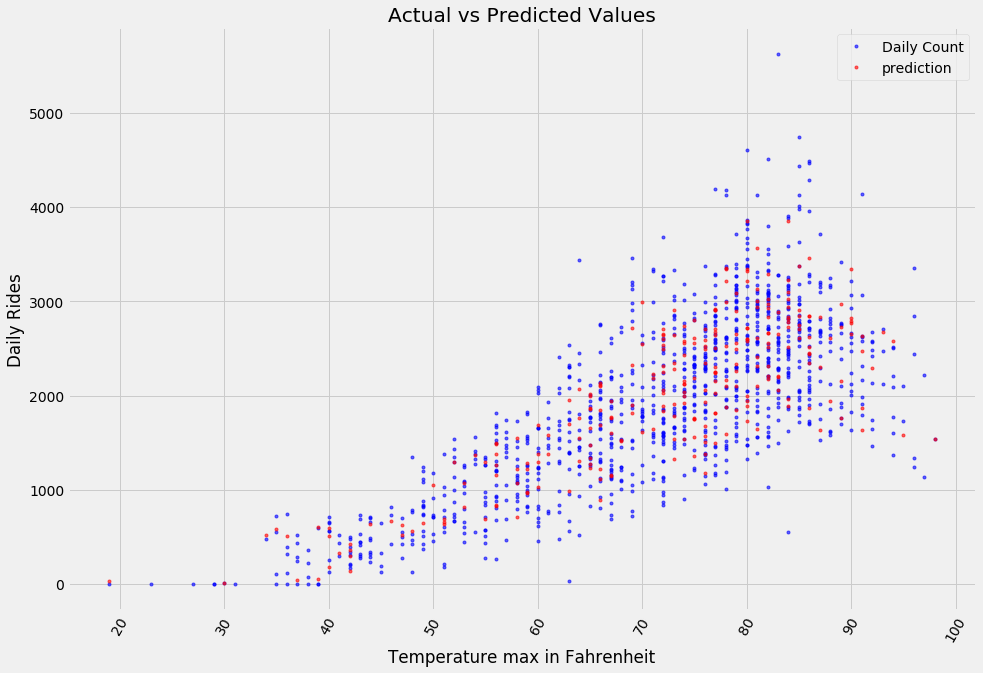

In [92]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'DCOUNT': target})

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,5], 'prediction': predictions})

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['DCOUNT'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');

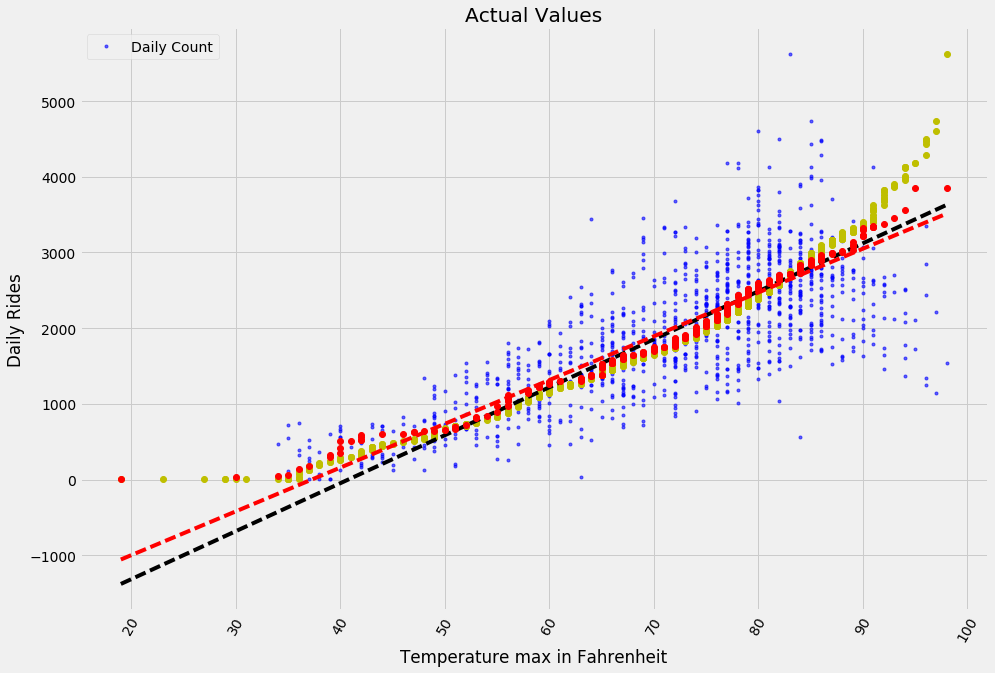

In [93]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'daily_count': target}) 

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['daily_count'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)

x = sorted(true_data['TMAX'].values) 
y = sorted(true_data['daily_count'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')

x = sorted(predictions_data['TMAX'].values) 
y = sorted(predictions_data['prediction'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k', color='red')

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual Values');

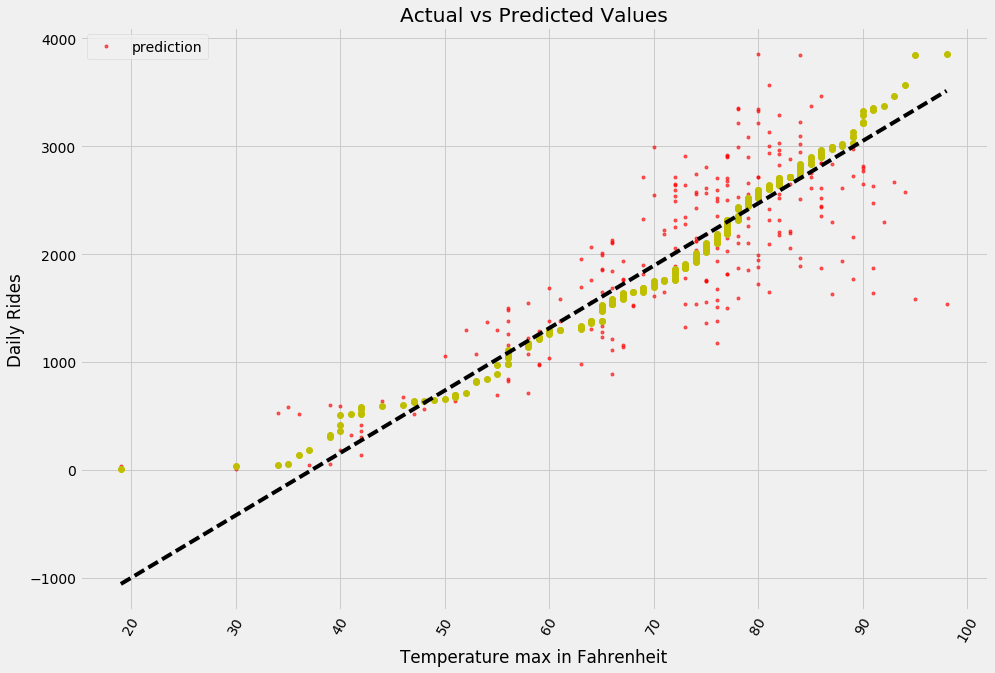

In [94]:
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,5], 'prediction': predictions})

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)

x = sorted(predictions_data['TMAX'].values) 
y = sorted(predictions_data['prediction'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');

## Testing

In [95]:
winter_features.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
count,1842.000000,1842.000000,1842.000000,1842.000000,1842.000000,1842.000000,1842.000000,1842.0,1842.0,1842.000000,1842.000000,1842.000000,1842.000000
mean,8.923708,0.066194,0.188871,2.266558,39.364821,47.539088,31.028773,0.0,0.0,2012.623779,6.200869,15.686754,0.286645
std,3.724765,0.217675,0.862654,4.226614,22.883052,24.141891,22.204245,0.0,0.0,2.249785,4.009608,8.770731,0.452317
min,0.890000,0.000000,0.000000,0.000000,-17.000000,-12.000000,-23.000000,0.0,0.0,2010.000000,1.000000,1.000000,0.000000
25%,6.260000,0.000000,0.000000,0.000000,23.000000,30.000000,15.000000,0.0,0.0,2011.000000,2.000000,8.000000,0.000000
50%,8.500000,0.000000,0.000000,0.000000,36.000000,43.000000,30.000000,0.0,0.0,2012.000000,6.000000,16.000000,0.000000
75%,11.180000,0.010000,0.000000,2.000000,57.500000,67.000000,47.000000,0.0,0.0,2014.000000,11.000000,23.000000,1.000000
max,24.610000,2.580000,16.300000,24.000000,91.000000,103.000000,81.000000,0.0,0.0,2017.000000,12.000000,31.000000,1.000000


** What should be used for the DCOUNT data? **

In [96]:
winter_target = winter_features.daily_count.values

winter_feat = winter_features.drop('daily_count', axis=1).values
winter_names = list(winter_features.drop('daily_count', axis=1).columns)

In [97]:
# Splitting the data into training and test sets
wX, wX_test, wy, wy_test = train_test_split(winter_feat, winter_target, test_size=.25, random_state=42)

In [98]:
predictions = rf.predict(wX_test)

## Assessing the performance of our RandomForestRegressor

This is the r2 score

In [99]:
cv_score = cross_val_score(rf, wX, wy, cv=10)
print(cv_score)
print(np.mean(cv_score))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


In [100]:
errors = abs(predictions - wy_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2))

Mean Absolute Error:  705.85


In [101]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / wy_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', np.round(accuracy, 2), '%')

Accuracy:  -inf %


/home/grimoire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


## Playing with cross_val_score

In [102]:
'''
['class#accuracy', 'adjusted_mutual_info_score', 'clus#adjusted_rand_score', 'class#average_precision', 
'clus#completeness_score', 'explained_variance', 'class#f1', 'class#f1_macro', 'class#f1_micro', 'class#f1_samples', 
'class#f1_weighted', 'clus#fowlkes_mallows_score', 
'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 
'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 
'class#recall', 'class#recall_macro', 'class#recall_micro', 'class#recall_samples', 'class#recall_weighted', 
'class#roc_auc', 'clus#v_measure_score']
'''

"\n['class#accuracy', 'adjusted_mutual_info_score', 'clus#adjusted_rand_score', 'class#average_precision', \n'clus#completeness_score', 'explained_variance', 'class#f1', 'class#f1_macro', 'class#f1_micro', 'class#f1_samples', \n'class#f1_weighted', 'clus#fowlkes_mallows_score', \n'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', \n'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', \n'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', \n'class#recall', 'class#recall_macro', 'class#recall_micro', 'class#recall_samples', 'class#recall_weighted', \n'class#roc_auc', 'clus#v_measure_score']\n"